#### The purpose of this notebook is to confirm each of our root files are not corrupted.

In [28]:
import uproot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm
import pandas as pd
import math
from scipy import stats
import os
import random
from numba import jit, njit, vectorize, cuda
from scipy.spatial.distance import cdist

In [29]:
IFT_79_00 = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit_79_00.root")
IFT_79_01 = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit_79_01.root")
IFT_79_02 = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit_79_02.root")
IFT_test = uproot.open("../../FASER-Track-Matching/IFT/trackerspfit.root")

In [30]:
def DefineIFT(data, status=''):
    if status =='first': # first layer
        position = ak.where(ak.num(data)==3)
        result = ak.firsts(data[position])  
    elif status == 'second': # second layer
        result = ak.mask(data, ak.num(data)==3)[:, 1]
        result = result[~ak.is_none(result)]
    elif status == 'third': # third layer
        result = ak.mask(data, ak.num(data)==3)[:, -1]
        result = result[~ak.is_none(result)]
    else:
        print('missing element')
    return result

def ConvertPanda(data, status):
    dict = {"x": DefineIFT(data['sp_track_x'], status=status), "y":DefineIFT(data['sp_track_y'], status=status), "z":DefineIFT(data['sp_track_z'], status=status),
            'x error':DefineIFT(data['sp_track_x_err'], status=status), 'y error':DefineIFT(data['sp_track_y_err'], status=status), 
            "tx":DefineIFT(data['track_p1'], status=status), "ty":DefineIFT(data['track_p3'], status=status)}
    return pd.DataFrame(dict)

In [31]:
def makePDforIFt(data):
    tree = data['spfit']
    ift = tree.arrays(['sp_track_x',
                       'sp_track_y',
                       'sp_track_z',
                       'sp_track_x_err',
                       'sp_track_y_err',
                       'sp_track_z_err',
                       'sp_track_x_predicted',
                       'sp_track_y_predicted',
                       'sp_track_z_predicted',
                       'sp_track_x_residual',
                       'sp_track_y_residual',
                       'sp_track_z_residual',
                       'track_p1',                  # tx
                       'track_p3'], library='ak')   # ty

    ift_first_layer = ConvertPanda(ift, 'first')
    ift_second_layer = ConvertPanda(ift, 'second')
    ift_third_layer = ConvertPanda(ift, 'third')
    
    return [ift_first_layer, ift_second_layer, ift_third_layer]

    

In [32]:
ift_79_00 = makePDforIFt(IFT_79_00)
ift_79_01 = makePDforIFt(IFT_79_01)
ift_79_02 = makePDforIFt(IFT_79_02)

### Seperate IFT to 4 different modules

In [33]:
def plane_selc(data, cen, size, layer_num):
    #name = 0 if data_name=='first' else 1 if data_name=='second' else 2
    min, max = (cen - size), (cen + size)
    
    win = data[layer_num][data[layer_num]['z'] >= min]
    win = win = win[win['z'] <= max]
    return win

def tracking_plane(data, layer_num):
    #name = 0 if data_name=='first' else 1 if data_name=='second' else 2
    bin = np.linspace(238, 252, 141) if layer_num==0 else np.linspace(270, 284, 141) if layer_num==1 else np.linspace(300, 315, 151)  # hard coded? confirm with david

    bin, count = np.histogram(data[layer_num], bins=bin)
    module_loc = [count[i] for i in range(len(bin)) if bin[i] != 0]

    module = []
    for i in range(len(module_loc)):
        module.append(plane_selc(data=data, cen=module_loc[i],size=0.1, layer_num=layer_num))

    #print(f'On {layer_num} layer, check if Sum of 4 modules = all data: {(len(module[0]) + len(module[1]) + len(module[2]) + len(module[3])) / len(data) * 100}% of ift data is distributed')

    return module

def plotting_planes(data, plane, ):
    plt.figure(figsize=(22, 10))
    plt.subplot(1, 2, 1)
    plt.title('Tracking station ' + str(plane))
    plt.scatter(data[0]['x'], data[0]['y'],marker='.', label='module 1 & 2')
    plt.scatter(data[1]['x'], data[1]['y'],marker='.', label='module 3 & 4')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.title('Tracking station ' + str(plane))
    plt.scatter(data[2]['x'], data[2]['y'],marker='.', label='module 5 & 6')
    plt.scatter(data[3]['x'], data[3]['y'],marker='.', label='module 7 & 8')
    plt.legend()
    plt.show()
    
    
    

In [34]:
ift_plane1 = tracking_plane(ift_79_00, 0)
#plotting_module(ift_module1, 0, 2)
ift_plane2 = tracking_plane(ift_79_00, 1)
#plotting_module(ift_module2, 1, 2)
ift_plane3 = tracking_plane(ift_79_00, 2)
#plotting_module(ift_module3, 2, 2)

In [35]:
print(len(ift_plane1), len(ift_plane2), len(ift_plane3))

4 4 4


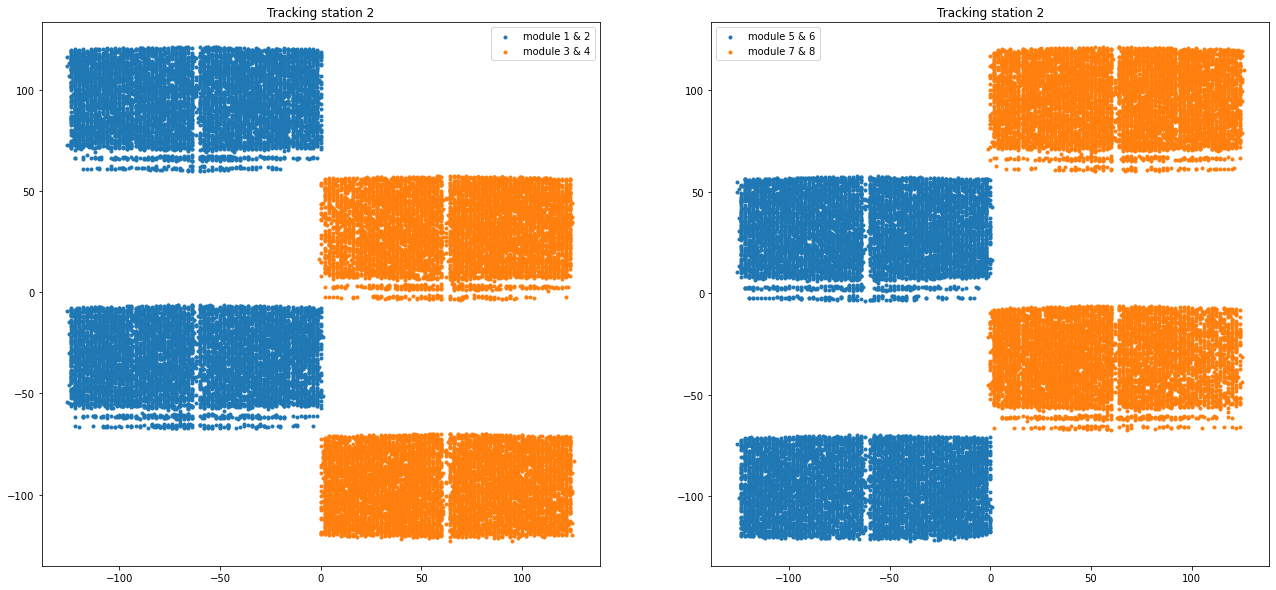

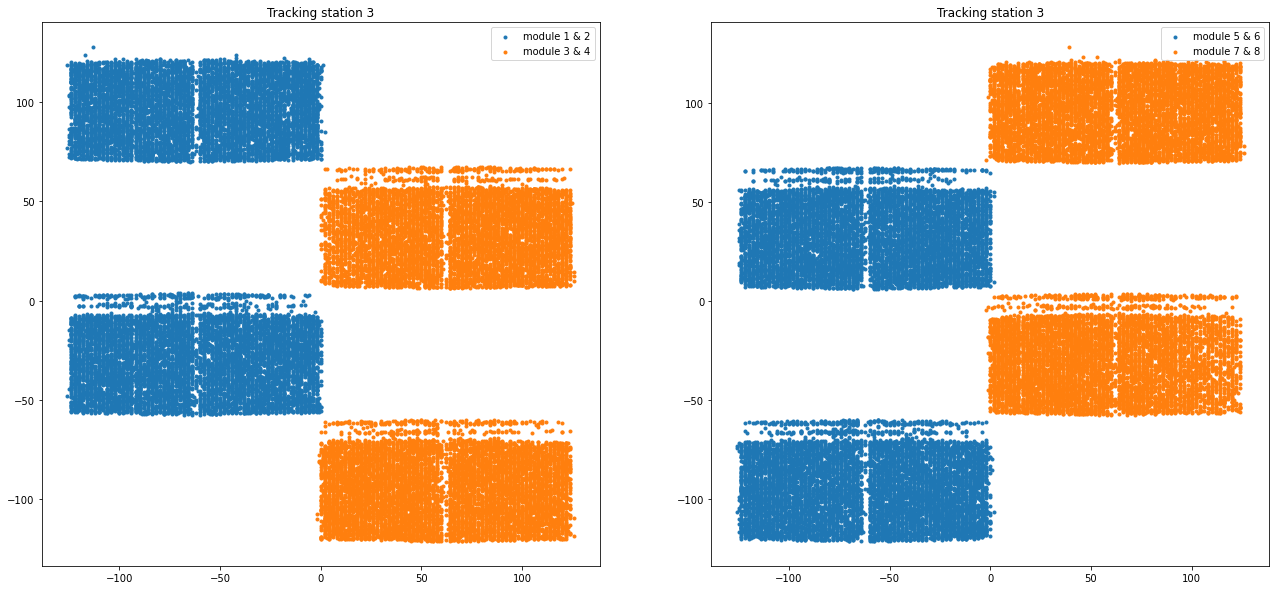

In [36]:
plotting_planes(ift_plane1, 1)
plotting_planes(ift_plane2, 2)
plotting_planes(ift_plane3, 3)

### Cuts on ty

In [37]:
def Filter(data, ty_lower_cut, ty_upper_cut=0, ty='ty', upper=False):
    mean = np.mean(data[ty])
    filter1 = data[data[ty] > (mean + ty_lower_cut)]
    filter2 = data[data[ty] < (mean - ty_lower_cut)]
    filter12 = pd.concat([filter1, filter2])
    filter = filter12
    if upper:
        filter3 = filter[filter[ty] > (mean - ty_upper_cut)]
        filter4 = filter3[filter3[ty] < (mean + ty_upper_cut)]
        filter = filter4
    print(f'{len(filter)/len(data)*100}% data is selected after cut')
    return filter

ift_filter = Filter(ift, ty_lower_cut=0.5, ty_upper_cut=0.74, upper=True)

NameError: name 'ift' is not defined